In [68]:
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd

# Load and preprocess data

In [69]:
def load_data(data_path = "dataF8k/captions.txt"):
    return pd.read_csv(data_path, header = 0)

data = load_data()
print("number of captions:", data.shape[0])
# data.head()

number of captions: 40455


In [70]:
# add unique start word ">>>" (stop word = "." already present in data)
data["caption_with_start"] = ">>> " + data["caption"].str.lower()
# data.head()

In [72]:
# Tokenize captions, keeping all words that appear at least 5 times
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '') # don't filter punctuation
tokenizer.fit_on_texts(data["caption_with_start"])

count_thres = 5
low_count_words = [w for w,c in tokenizer.word_counts.items() if c < count_thres]
for w in low_count_words:
    del tokenizer.word_index[w]
    del tokenizer.word_docs[w]
    del tokenizer.word_counts[w]

data["token_caption"] = tokenizer.texts_to_sequences(data["caption_with_start"])

data.head()

,image,caption,caption_with_start,token_caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,>>> a child in a pink dress is climbing up a s...,"[2, 1, 43, 4, 1, 91, 171, 7, 120, 54, 1, 397, ..."
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,>>> a girl going into a wooden building .,"[2, 1, 19, 316, 65, 1, 195, 118, 3]"
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,>>> a little girl climbing into a wooden playh...,"[2, 1, 41, 19, 120, 65, 1, 195, 2437, 3]"
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,>>> a little girl climbing the stairs to her p...,"[2, 1, 41, 19, 120, 5, 394, 21, 61, 2437, 3]"
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,>>> a little girl in a pink dress going into a...,"[2, 1, 41, 19, 4, 1, 91, 171, 316, 65, 1, 195, 3]"


In [133]:
num_words = len(tokenizer.word_counts)
image = data["image"].to_numpy()
caption = np.array(data["caption"])
caption_tok = tokenizer.texts_to_sequences(caption)

caption_oh =[]
for c in caption_tok:
    oh_tensor = tf.one_hot(np.array(c), num_words)
    caption_oh.append(np.array(oh_tensor))
print(caption_oh[0])

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
data["caption_from_token"] = tokenizer.sequences_to_texts(data["token_caption"])
print("number of captions with removed words:" , (data.query('caption_from_token != caption_with_start').shape[0]))

number of captions with removed words: 8000


# Prepare CNN model

In [7]:
# Import CNN model and labels
# By setting include_top to false we can remove the last fully connected layer of the network. 
# (which I believe is what we want for our complete model)
# But leave it here for testing, we will import the cnn without top later
cnn = tf.keras.applications.DenseNet201(include_top = True) 

labels_path = tf.keras.utils.get_file(
    'ImageNetLabels.txt',
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels = np.array(open(labels_path).read().splitlines())

[0.95036507 0.02135203 0.00573725 0.00268194 0.00191947]
['motor scooter' 'crane' 'eggnog' 'monitor' 'bib']


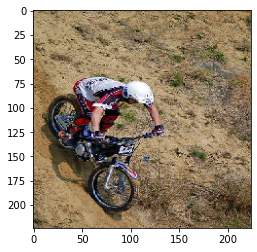

In [8]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Test on an image
img = load_img("dataF8k/Images/479807115_3a484fb18b.jpg", target_size=(224, 224))
plt.imshow(img)
x = img_to_array(img) 
x = x.reshape((1,) + x.shape) 

x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

predictions = cnn.predict(x)
top_5_classes_index = np.argsort(predictions)[0 , ::-1][:5]
print(predictions[0,top_5_classes_index])
top_5_classes = labels[top_5_classes_index]
print(top_5_classes)

In [9]:
cnn4nw = tf.keras.applications.DenseNet201(include_top = False) 

In [16]:
# TODO: CNN embedding layer: last layer -> 512 dimensions
# tf.keras.utils.plot_model(cnn4nw, "cnn_arch.png", show_shapes=True)
# for l in cnn4nw.layers:
#     print (l.output_shape)
# output last layer has size 1920



AttributeError: 'list' object has no attribute 'shape'

In [11]:
#TODO: Word embedding layer: one-hot vector of vocab size --> 512 dimensions
#TODO: LTSM layer with 512 dim memory
#TODO: output layer of vocab size, softmax activation